## Introduction

This kernel forked from WM-811k Wafermap [https://www.kaggle.com/ashishpatel26/wm-811k-wafermap].
This dataset has various wafer resolution with class imbalanced. so I just consider specific subset wafer that has 26x26 resolution.
and solve imbalance problem using 2D convolutional autoencoder. then, classfy faulty case labels.

In [2]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
#from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'numpy'

## Read Data

In [2]:
df=pd.read_pickle("./data/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- The dataset comprises **811,457 wafer maps**, along with additional information such as **wafer die size, lot name and wafer index.**

- The training / test set were already split by domain experts, but in this kernel we ignore this info and we re-divided the dataset into training set and test set by hold-out mehtod which will be introduced in later section.

In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


- The dataset were collected from **47,543 lots** in real-world fab. However, 47,543 lots x 25 wafer/lot =1,157,325 wafer maps is larger than 811,457 wafer maps.

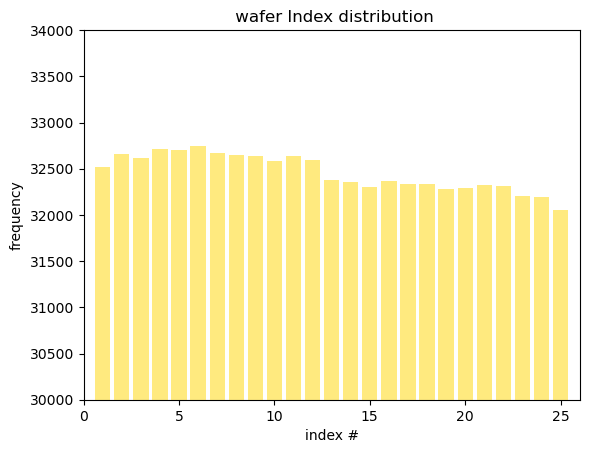

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

- The figure shows that not all lots have perfect 25 wafer maps and it may caused by sensor failure or other unknown problems.

- Fortunately, we do not need wafer index feature in our classification so we can just drop the variable.

In [6]:
df = df.drop(['waferIndex'], axis = 1)

- We can not get much information from the wafer map column but we can see the die size for each instance is different.

- We create a **new variable 'waferMapDim'** for wafer map dim checking.

In [7]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
169015,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot10808,[[Training]],[[Loc]],"(52, 59)"
713472,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",516.0,lot43566,[[Test]],[[none]],"(25, 27)"
274524,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1139.0,lot16914,[],[],"(38, 38)"
377218,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2126.0,lot22478,[[Training]],[[Edge-Ring]],"(53, 52)"
511706,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...",515.0,lot31896,[],[],"(25, 27)"


### Get sub wafer with specific resolution.
- get wafers have (26, 26) resolution. rarrange wafer nd-array with fautly case label.
- some wafer has null label, skip it.

In [8]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [9]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [10]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


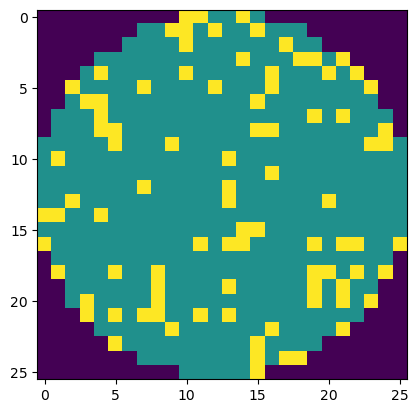

Faulty case : ['none'] 


In [11]:
# plot 1st data for check
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

We will use 2D Convolutional Autoencoder, extend dimension for channel.

In [12]:
#add channel
x = x.reshape((-1, 26, 26, 1))

Make faulty case list, and check how classes imbalanced.

In [13]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [14]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


Wafer data's each pixels have a categorical variable that express 0 : not wafer, 1 : normal, 2 : faulty.
Extend extra dimension with one-hot-encoded categorical data as channel.
that idea from Data Science & Business Analytics Lab, School of Industrial Management Engineering, College of Engineering, Korea University[http://dsba.korea.ac.kr/main]

In [15]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [16]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

## Convolutional Autoencoder for augmentation.
- As solving class imbalanced problem, we need for data augmentation.
- The wafer data is image data. so we use convolutional autoencoder.

In [46]:
# parameter
epoch=5
batch_size=1024

In [18]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [19]:
# Check Summary
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_transpose (Conv2DTr  (None, 13, 13, 64)        36928     
 anspose)                                                        
                                                                 
 up_sampling2d (UpSampling2  (None, 26, 26, 64)        0         
 D)                                                              
                                                             

In [20]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/15
15/15 - 16s - loss: 0.1545 - 16s/epoch - 1s/step
Epoch 2/15
15/15 - 15s - loss: 0.0954 - 15s/epoch - 992ms/step
Epoch 3/15
15/15 - 15s - loss: 0.0851 - 15s/epoch - 1s/step
Epoch 4/15
15/15 - 16s - loss: 0.0732 - 16s/epoch - 1s/step
Epoch 5/15
15/15 - 16s - loss: 0.0631 - 16s/epoch - 1s/step
Epoch 6/15
15/15 - 16s - loss: 0.0557 - 16s/epoch - 1s/step
Epoch 7/15
15/15 - 16s - loss: 0.0503 - 16s/epoch - 1s/step
Epoch 8/15
15/15 - 16s - loss: 0.0455 - 16s/epoch - 1s/step
Epoch 9/15
15/15 - 15s - loss: 0.0406 - 15s/epoch - 1s/step
Epoch 10/15
15/15 - 16s - loss: 0.0358 - 16s/epoch - 1s/step
Epoch 11/15
15/15 - 15s - loss: 0.0316 - 15s/epoch - 1s/step
Epoch 12/15
15/15 - 15s - loss: 0.0280 - 15s/epoch - 1s/step
Epoch 13/15
15/15 - 18s - loss: 0.0251 - 18s/epoch - 1s/step
Epoch 14/15
15/15 - 20s - loss: 0.0226 - 20s/epoch - 1s/step
Epoch 15/15
15/15 - 20s - loss: 0.0206 - 20s/epoch - 1s/step


In [21]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [22]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [23]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

449/449 [==============================] - 4s 8ms/step


In [24]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

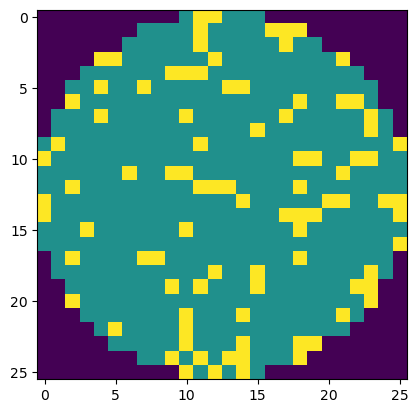

In [25]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

449/449 [==============================] - 7s 15ms/step


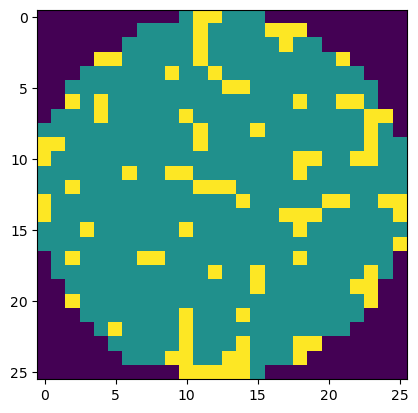

In [26]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

449/449 [==============================] - 9s 19ms/step


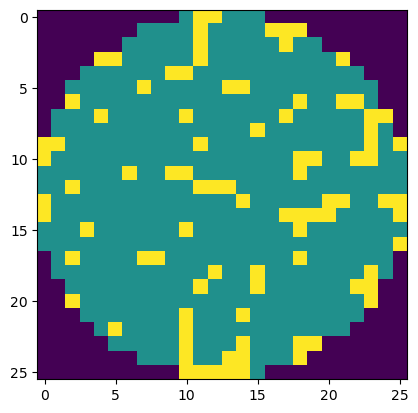

In [27]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

## Data augmentation
- We made convolutional autoencoder model for data augmentation.
- I just want data has 2000 samples for each case. Let's augment data for all faulty case.

In [28]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [29]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 29ms/step


3/3 [==============================] - 0s 10ms/step


In [30]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [31]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [32]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [33]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [34]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [35]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [36]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [37]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [38]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (13203, 26, 26, 3), y : (13203, 9)
Test x: (6504, 26, 26, 3), y : (6504, 9)


## Simple 2D CNN Model
The data is ready. As wafer data is image. simply use cnn for classification.

**Make model**

define create model function, because we will validate model with sklearn kfold cross validation.

In [39]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

**Cross validate model**

Using sklearn KFold Cross validation, we validate our simple cnn.

In [40]:
from scikeras.wrappers import KerasClassifier
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/10
9/9 - 71s - loss: 2.9908 - accuracy: 0.2184 - 71s/epoch - 8s/step
Epoch 2/10
9/9 - 70s - loss: 1.2975 - accuracy: 0.5186 - 70s/epoch - 8s/step
Epoch 3/10
9/9 - 69s - loss: 0.7991 - accuracy: 0.6923 - 69s/epoch - 8s/step
Epoch 4/10
9/9 - 69s - loss: 0.4947 - accuracy: 0.8344 - 69s/epoch - 8s/step
Epoch 5/10
9/9 - 68s - loss: 0.3774 - accuracy: 0.8859 - 68s/epoch - 8s/step
Epoch 6/10
9/9 - 61s - loss: 0.2236 - accuracy: 0.9275 - 61s/epoch - 7s/step
Epoch 7/10
9/9 - 63s - loss: 0.1262 - accuracy: 0.9627 - 63s/epoch - 7s/step
Epoch 8/10
9/9 - 59s - loss: 0.1244 - accuracy: 0.9606 - 59s/epoch - 7s/step
Epoch 9/10
9/9 - 60s - loss: 0.0915 - accuracy: 0.9777 - 60s/epoch - 7s/step
Epoch 10/10
9/9 - 59s - loss: 0.6084 - accuracy: 0.8611 - 59s/epoch - 7s/step
5/5 - 8s - 8s/epoch - 2s/step
Epoch 1/10
9/9 - 65s - loss: 2.6390 - accuracy: 0.1968 - 65s/epoch - 7s/step
Epoch 2/10
9/9 - 59s - loss: 1.2446 - accuracy: 0.5963 - 59s/epoch - 7s/step
Epoch 3/10
9/9 - 59s - loss: 0.7606 - accurac

In [47]:
history = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         epochs=epoch,
         batch_size=batch_size,
         )

Epoch 1/5
13/13 - 126s - loss: 1.6341 - accuracy: 0.4660 - val_loss: 0.8719 - val_accuracy: 0.7080 - 126s/epoch - 10s/step
Epoch 2/5
13/13 - 119s - loss: 0.6980 - accuracy: 0.7836 - val_loss: 0.3916 - val_accuracy: 0.8761 - 119s/epoch - 9s/step
Epoch 3/5
13/13 - 83s - loss: 0.2901 - accuracy: 0.9051 - val_loss: 0.1694 - val_accuracy: 0.9474 - 83s/epoch - 6s/step
Epoch 4/5
13/13 - 90s - loss: 0.1209 - accuracy: 0.9638 - val_loss: 0.0962 - val_accuracy: 0.9705 - 90s/epoch - 7s/step
Epoch 5/5
13/13 - 102s - loss: 0.0521 - accuracy: 0.9852 - val_loss: 0.0489 - val_accuracy: 0.9852 - 102s/epoch - 8s/step
